In [ ]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
num_sample = mnist.train.num_examples
input_dim = mnist.train.images[0].shape[0]
w = h = int(np.sqrt(input_dim))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
class Autoencoder(object):

    def __init__(self, input_dim =input_dim, learning_rate=1e-4, batch_size=64, n_z=16):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z
        self.input_dim = input_dim

        tf.reset_default_graph()
        self.build()

        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        self.x = tf.placeholder(
            name='x', dtype=tf.float32, shape=[None, self.input_dim])

        # Encode
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.x, 256, scope='enc_fc1', activation_fn=tf.nn.relu)
        f2 = fc(f1, 128, scope='enc_fc2', activation_fn=tf.nn.relu)
        f3 = fc(f2, 64, scope='enc_fc3', activation_fn=tf.nn.relu)
        self.z = fc(f3, self.n_z, scope='enc_fc4', activation_fn=tf.nn.relu)

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 64, scope='dec_fc1', activation_fn=tf.nn.relu)
        g2 = fc(g1, 128, scope='dec_fc2', activation_fn=tf.nn.relu)
        g3 = fc(g2, 256, scope='dec_fc3', activation_fn=tf.nn.relu)
        self.x_hat = fc(g3, self.input_dim, scope='dec_fc4', 
                        activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + 
            (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.recon_loss)
        
        self.losses = {
            'recon_loss': self.recon_loss
        }
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.x: x}
        )
        return losses

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z

In [6]:
def trainer(model_object, learning_rate=1e-4, 
            batch_size=64, num_epoch=100, n_z=16, log_step=5):
    model = model_object(
        learning_rate=learning_rate, batch_size=batch_size, n_z=n_z)

    for epoch in range(num_epoch):
        start_time = time.time()
        for iter in range(num_sample // batch_size):
            # Get a batch
            batch = mnist.train.next_batch(batch_size)
            # Execute the forward and backward pass 
            # Report computed losses
            losses = model.run_single_step(batch[0])
        end_time = time.time()
        
        if epoch % log_step == 0:
            log_str = '[Epoch {}] '.format(epoch)
            for k, v in losses.items():
                log_str += '{}: {:.3f}  '.format(k, v)
            log_str += '({:.3f} sec/epoch)'.format(end_time - start_time)
            print(log_str)
            
    print('Done!')
    return model

In [7]:
# Train a model
model = trainer(Autoencoder)

C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[Epoch 0] recon_loss: 170.897  (3.668 sec/epoch)
[Epoch 5] recon_loss: 105.109  (3.447 sec/epoch)
[Epoch 10] recon_loss: 95.012  (3.450 sec/epoch)
[Epoch 15] recon_loss: 89.837  (3.432 sec/epoch)
[Epoch 20] recon_loss: 85.340  (3.428 sec/epoch)
[Epoch 25] recon_loss: 81.137  (3.464 sec/epoch)
[Epoch 30] recon_loss: 80.531  (3.432 sec/epoch)
[Epoch 35] recon_loss: 70.675  (3.430 sec/epoch)
[Epoch 40] recon_loss: 80.741  (3.429 sec/epoch)
[Epoch 45] recon_loss: 73.375  (3.409 sec/epoch)
[Epoch 50] recon_loss: 77.466  (3.403 sec/epoch)
[Epoch 55] recon_loss: 77.561  (3.426 sec/epoch)
[Epoch 60] recon_loss: 77.016  (3.580 sec/epoch)
[Epoch 65] recon_loss: 79.441  (3.630 sec/epoch)
[Epoch 70] recon_loss: 73.619  (3.555 sec/epoch)
[Epoch 75] recon_loss: 71.613  (3.458 sec/epoch)
[Epoch 80] recon_loss: 79.798  (3.628 sec/epoch)
[Epoch 85] recon_loss: 69.111  (3.868 sec/epoch)
[Epoch 90] recon_loss: 72.692  (3.513 sec/epoch)
[Epoch 95] recon_loss: 70.054  (3.449 sec/epoch)
Done!


In [8]:
def test_reconstruction(model, mnist, h=28, w=28, batch_size=100):
    # Test the trained model: reconstruction
    batch = mnist.test.next_batch(batch_size)
    x_reconstructed = model.reconstructor(batch[0])

    n = np.sqrt(batch_size).astype(np.int32)
    I_reconstructed = np.empty((h*n, 2*w*n))
    for i in range(n):
        for j in range(n):
            x = np.concatenate(
                (x_reconstructed[i*n+j, :].reshape(h, w), 
                 batch[0][i*n+j, :].reshape(h, w)),
                axis=1
            )
            I_reconstructed[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = x

    plt.figure(figsize=(10, 20))
    plt.imshow(I_reconstructed, cmap='gray')

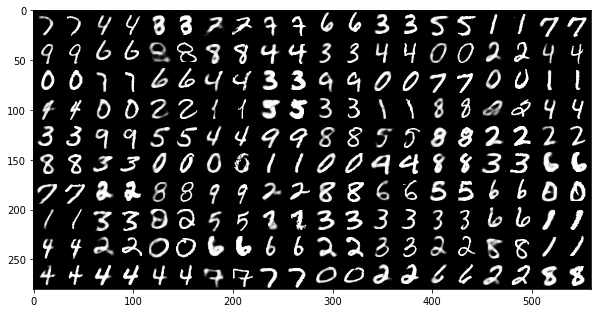

In [9]:
test_reconstruction(model, mnist)

In [10]:
# Train a model with 2d latent space
model_2d = trainer(Autoencoder, n_z=2)

[Epoch 0] recon_loss: 200.574  (3.536 sec/epoch)
[Epoch 5] recon_loss: 181.815  (6.392 sec/epoch)
[Epoch 10] recon_loss: 178.223  (3.543 sec/epoch)
[Epoch 15] recon_loss: 164.183  (3.760 sec/epoch)
[Epoch 20] recon_loss: 146.540  (4.524 sec/epoch)
[Epoch 25] recon_loss: 145.723  (3.643 sec/epoch)
[Epoch 30] recon_loss: 140.562  (5.254 sec/epoch)
[Epoch 35] recon_loss: 147.395  (3.410 sec/epoch)
[Epoch 40] recon_loss: 146.388  (3.605 sec/epoch)
[Epoch 45] recon_loss: 134.960  (3.445 sec/epoch)
[Epoch 50] recon_loss: 134.237  (3.465 sec/epoch)
[Epoch 55] recon_loss: 128.213  (3.420 sec/epoch)
[Epoch 60] recon_loss: 131.203  (3.524 sec/epoch)
[Epoch 65] recon_loss: 134.935  (3.733 sec/epoch)
[Epoch 70] recon_loss: 143.425  (3.655 sec/epoch)
[Epoch 75] recon_loss: 128.784  (3.738 sec/epoch)
[Epoch 80] recon_loss: 126.193  (3.434 sec/epoch)
[Epoch 85] recon_loss: 135.429  (3.407 sec/epoch)
[Epoch 90] recon_loss: 123.349  (3.469 sec/epoch)
[Epoch 95] recon_loss: 133.855  (3.463 sec/epoch)
Do

In [11]:
def test_transformation(model_2d, mnist, batch_size=3000):
    # Test the trained model: transformation
    assert model_2d.n_z == 2
    batch = mnist.test.next_batch(batch_size)
    z = model_2d.transformer(batch[0])
    plt.figure(figsize=(10, 8)) 
    plt.scatter(z[:, 0], z[:, 1], c=np.argmax(batch[1], 1), s=20)
    plt.colorbar()
    plt.grid()

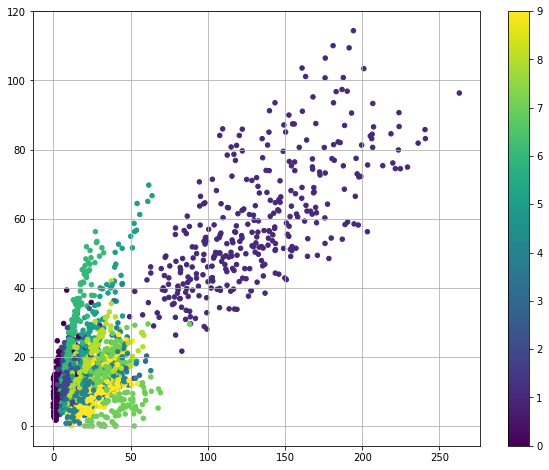

In [12]:
test_transformation(model_2d, mnist)

In [25]:
class VariantionalAutoencoder(object):

    def __init__(self, input_dim =input_dim, learning_rate=1e-4, batch_size=64, n_z=16):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z
        self.input_dim = input_dim

        tf.reset_default_graph()
        self.build()

        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        self.x = tf.placeholder(
            name='x', dtype=tf.float32, shape=[None, self.input_dim])

        # Encode
        # x -> z_mean, z_sigma -> z
        f0 = fc(self.x, 1024, scope='enc_fc0', activation_fn=tf.nn.relu)
        f1 = fc(f0, 256, scope='enc_fc1', activation_fn=tf.nn.relu)
        f2 = fc(f1, 128, scope='enc_fc2', activation_fn=tf.nn.relu)
        f3 = fc(f2, 64, scope='enc_fc3', activation_fn=tf.nn.relu)
        self.z_mu = fc(f3, self.n_z, scope='enc_fc4_mu', 
                       activation_fn=None)
        self.z_log_sigma_sq = fc(f3, self.n_z, scope='enc_fc4_sigma', 
                                 activation_fn=None)
        eps = tf.random_normal(
            shape=tf.shape(self.z_log_sigma_sq),
            mean=0, stddev=1, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 64, scope='dec_fc1', activation_fn=tf.nn.relu)
        g2 = fc(g1, 128, scope='dec_fc2', activation_fn=tf.nn.relu)
        g3 = fc(g2, 256, scope='dec_fc3', activation_fn=tf.nn.relu)
        g4 = fc(g3, 1024, scope='dec_fc3.5', activation_fn=tf.nn.relu)
        self.x_hat = fc(g4, self.input_dim, scope='dec_fc4', 
                        activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + 
            (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        # Latent loss
        # KL divergence: measure the difference between two distributions
        # Here we measure the divergence between 
        # the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - 
            tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)

        self.total_loss = self.recon_loss + self.latent_loss
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.total_loss)
        
        self.losses = {
            'recon_loss': self.recon_loss,
            'latent_loss': self.latent_loss,
            'total_loss': self.total_loss,
        }        
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.x: x}
        )
        return losses

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat

    # z -> x
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z

In [14]:
# Train a model
model_vae = trainer(VariantionalAutoencoder)

[Epoch 0] recon_loss: 186.039  latent_loss: 4.641  total_loss: 190.681  (4.085 sec/epoch)
[Epoch 5] recon_loss: 122.729  latent_loss: 15.041  total_loss: 137.770  (3.993 sec/epoch)
[Epoch 10] recon_loss: 105.603  latent_loss: 18.052  total_loss: 123.655  (3.667 sec/epoch)
[Epoch 15] recon_loss: 99.375  latent_loss: 18.279  total_loss: 117.655  (3.732 sec/epoch)
[Epoch 20] recon_loss: 92.244  latent_loss: 18.850  total_loss: 111.093  (3.702 sec/epoch)
[Epoch 25] recon_loss: 94.600  latent_loss: 19.538  total_loss: 114.138  (3.678 sec/epoch)
[Epoch 30] recon_loss: 98.473  latent_loss: 21.122  total_loss: 119.595  (3.676 sec/epoch)
[Epoch 35] recon_loss: 83.654  latent_loss: 20.053  total_loss: 103.707  (3.689 sec/epoch)
[Epoch 40] recon_loss: 86.306  latent_loss: 19.560  total_loss: 105.866  (3.698 sec/epoch)
[Epoch 45] recon_loss: 85.719  latent_loss: 19.534  total_loss: 105.253  (3.714 sec/epoch)
[Epoch 50] recon_loss: 91.265  latent_loss: 20.232  total_loss: 111.498  (3.850 sec/epoch)

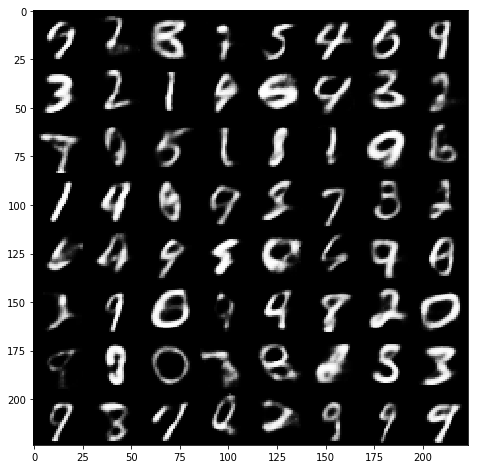

In [15]:
# Test the trained model: generation
# Sample noise vectors from N(0, 1)
z = np.random.normal(size=[model.batch_size, model.n_z])
x_generated = model_vae.generator(z)

n = np.sqrt(model.batch_size).astype(np.int32)
I_generated = np.empty((h*n, w*n))
for i in range(n):
    for j in range(n):
        I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = x_generated[i*n+j, :].reshape(h, w)

plt.figure(figsize=(8, 8))
plt.imshow(I_generated, cmap='gray')

In [16]:
# Train a model with 2d latent space
model_2d_vae = trainer(VariantionalAutoencoder, n_z=2)

[Epoch 0] recon_loss: 201.415  latent_loss: 3.987  total_loss: 205.402  (3.929 sec/epoch)
[Epoch 5] recon_loss: 165.775  latent_loss: 4.621  total_loss: 170.395  (3.597 sec/epoch)
[Epoch 10] recon_loss: 152.192  latent_loss: 5.056  total_loss: 157.249  (3.703 sec/epoch)
[Epoch 15] recon_loss: 147.810  latent_loss: 5.639  total_loss: 153.448  (3.588 sec/epoch)
[Epoch 20] recon_loss: 157.148  latent_loss: 5.890  total_loss: 163.038  (3.595 sec/epoch)
[Epoch 25] recon_loss: 137.427  latent_loss: 5.696  total_loss: 143.122  (3.595 sec/epoch)
[Epoch 30] recon_loss: 146.663  latent_loss: 5.793  total_loss: 152.455  (3.582 sec/epoch)
[Epoch 35] recon_loss: 140.945  latent_loss: 5.884  total_loss: 146.829  (3.635 sec/epoch)
[Epoch 40] recon_loss: 143.835  latent_loss: 6.143  total_loss: 149.979  (3.604 sec/epoch)
[Epoch 45] recon_loss: 147.326  latent_loss: 6.128  total_loss: 153.454  (3.630 sec/epoch)
[Epoch 50] recon_loss: 142.716  latent_loss: 6.083  total_loss: 148.799  (3.605 sec/epoch)
[

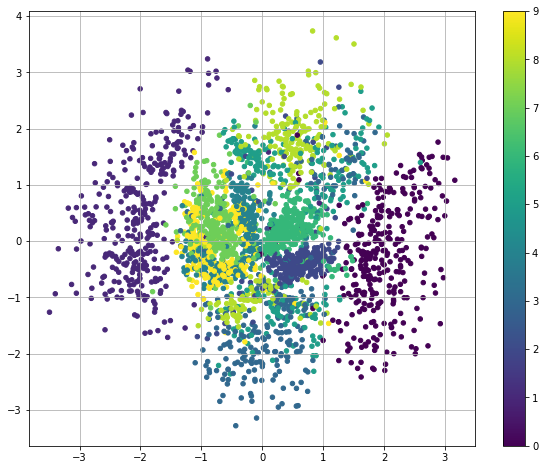

In [17]:
test_transformation(model_2d_vae, mnist)

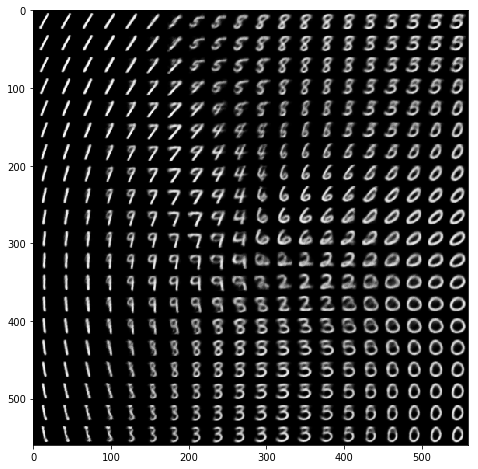

In [18]:
# Test the trained model: uniformly samlpe in the latent space
n = 20
x = np.linspace(-2, 2, n)
y = np.linspace(-2, 2, n)

I_latent = np.empty((h*n, w*n))
for i, yi in enumerate(x):
    for j, xi in enumerate(y):
        z = np.array([[xi, yi]]*model_2d_vae.batch_size)
        x_hat = model_2d_vae.generator(z)
        I_latent[(n-i-1)*h:(n-i)*h, j*w:(j+1)*w] = x_hat[0].reshape(h, w)

plt.figure(figsize=(8, 8))        
plt.imshow(I_latent, cmap="gray")

In [19]:
import os, time, itertools, pickle, random, glob, imageio
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
import math

In [20]:
def dataset_load_album(datapath, labelpath, imgsize):
    """
    datapath 'jpeg' file of album image
    labelpath 'png' file of spectrogram 
    """
    datalist = os.listdir(datapath)
    datasize = len(datalist)
    
    data_ = np.zeros((datasize, imgsize, imgsize, 3))
    label_ = np.zeros((datasize, imgsize, imgsize, 3))
    nonelist = []
    for i, fname in enumerate(datalist):
        if glob.glob(os.path.join(labelpath, fname[:-4] + '*')):
        #f os.path.isfile(os.path.join(labelpath, fname[:-4] + 'png')):
            #print('there is file')
            img_d = Image.open(os.path.join(datapath, fname)
                              ).resize((imgsize, imgsize))
            img_l = Image.open(os.path.join(labelpath, fname[:-4]+'png')
                              ).convert('RGB').resize((imgsize, imgsize))
            data_[i] = np.asarray(img_d)
            label_[i] = np.asarray(img_l)
            
        else:
            nonelist.append(i)
            
    data = np.delete(data_, nonelist, 0)
    label = np.delete(label_, nonelist, 0)
    return data, label

In [21]:
# Load albumdata
datapath = os.path.join('input', 'img')
samples, labels = dataset_load_album(
    'input/img', 'audio/spec', 32)

samples = samples/255
labels = labels/255

In [22]:
samples.shape

(131, 32, 32, 3)

In [26]:
def trainer_album(model_object, sample, input_dim =input_dim, learning_rate=1e-4, 
            batch_size=64, num_epoch=100, n_z=16, log_step=5):
    model = model_object(
        learning_rate=learning_rate, batch_size=batch_size, n_z=n_z,
    input_dim =input_dim)
    step = 0

    for epoch in range(num_epoch):
        start_time = time.time()
        for iter in range(num_sample // batch_size):
            step += 1
            # Get a batch
            batch = sample[i * batch_size : (i + 1) * batch_size]
            # Execute the forward and backward pass 
            # Report computed losses
            losses = model.run_single_step(batch)
        end_time = time.time()
        
        if epoch % log_step == 0:
            log_str = '[Epoch {}] '.format(epoch)
            for k, v in losses.items():
                log_str += '{}: {:.3f}  '.format(k, v)
            log_str += '({:.3f} sec/epoch)'.format(end_time - start_time)
            print(log_str)
            
    print('Done!')
    return model

In [27]:
model_2d_vae = trainer_album(VariantionalAutoencoder,
                             samples.reshape(-1,32*32*3), input_dim =32*32*3, batch_size=16, n_z=2)

AbortedError: Operation received an exception:Status: 5, message: could not create a primitive descriptor iterator, in file tensorflow/core/kernels/mkl_relu_op.cc:871
	 [[node enc_fc0/Relu (defined at <ipython-input-25-58b1a2fb1369>:22) ]]

Caused by op 'enc_fc0/Relu', defined at:
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\asyncio\base_events.py", line 539, in run_forever
    self._run_once()
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\asyncio\base_events.py", line 1775, in _run_once
    handle._run()
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\IPython\core\interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\IPython\core\interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\IPython\core\interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-15d9318c6973>", line 2, in <module>
    samples.reshape(-1,32*32*3), input_dim =32*32*3, batch_size=16, n_z=2)
  File "<ipython-input-26-d8eb01164607>", line 5, in trainer_album
    input_dim =input_dim)
  File "<ipython-input-25-58b1a2fb1369>", line 10, in __init__
    self.build()
  File "<ipython-input-25-58b1a2fb1369>", line 22, in build
    f0 = fc(self.x, 1024, scope='enc_fc0', activation_fn=tf.nn.relu)
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\tensorflow\contrib\framework\python\ops\arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\tensorflow\contrib\layers\python\layers\layers.py", line 1869, in fully_connected
    outputs = activation_fn(outputs)
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 9196, in relu
    "Relu", features=features, name=name)
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

AbortedError (see above for traceback): Operation received an exception:Status: 5, message: could not create a primitive descriptor iterator, in file tensorflow/core/kernels/mkl_relu_op.cc:871
	 [[node enc_fc0/Relu (defined at <ipython-input-25-58b1a2fb1369>:22) ]]


In [ ]:
samples.reshape(-1,32*32*3).shape

In [32]:
samples.reshape(-1,32*32*3)[0]

array([1., 1., 1., ..., 1., 1., 1.])

array([[[1.        , 1.        , 1.        ],
        [1.        , 0.99607843, 0.98039216],
        [1.        , 1.        , 0.99215686],
        ...,
        [1.        , 1.        , 1.        ],
        [0.98823529, 1.        , 0.99215686],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 0.99215686],
        [0.81568627, 0.7372549 , 0.5372549 ],
        [0.81176471, 0.72941176, 0.52156863],
        ...,
        [0.98431373, 0.98431373, 0.98431373],
        [0.76862745, 0.66666667, 0.44313725],
        [1.        , 0.98823529, 1.        ]],

       [[1.        , 0.99607843, 0.97647059],
        [0.83137255, 0.76862745, 0.56862745],
        [0.77254902, 0.69411765, 0.49803922],
        ...,
        [1.        , 1.        , 0.98431373],
        [0.81960784, 0.72156863, 0.49803922],
        [1.        , 0.99215686, 1.        ]],

       ...,

       [[0.99607843, 0.99607843, 0.99607843],
        [0.01960784, 0.01960784, 0.01960784],
        [0.02352941, 0